# Detector resolution
**WARNING**: This exercise requires a larger data sample than the one available with the git repository. Please download beforehand the 2022D directory from the course sharepoint.

As you know, detectors are not perfect and do not provide an infinitely precise measurement. Instead they have resolutions that may be a constant value, or may depend on the measured value itself.
In this notebook we will explore the energy resolution of the LKr detector, and the time and momentum resolution of the Spectrometer.

The resolution is the difference that we may find between the measured value and a reference value (the "real" value). Unless working with simulation, we usually cannot know the exact real value. So we need to find either a reference value which was measured with a resolution that was much smaller than the resolution that we are trying to measure. This would give us an "exact" value for all practical purposes. Alternatively we can measure the resolution with respect to another measurement for which the resolution is already well known, or with respect to another measurement provided by the same detector (if this is practical). For these two last cases, the measured resolution will be the convolution of both measurements but the resolution of the tested detector can be obtained by deconvolution. 

In [1]:
# As usual let's import all we need
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from na62 import prepare, hlf, extract, constants, stats
from lmfit import Model

In [2]:
# Then we load the data, but this time we will load 10 data files at once
from pathlib import Path
datafiles = sorted(Path("Full_DataSample/2022D").glob("run*.root"))[:10]
data, _ = prepare.import_root_files(datafiles)

# LKr energy resolution
To measure the LKr energy resolution we can use one of the principles that we have seen in the PID notebook. We know that in almost 100% of the cases, electrons will leave all their energy inside the LKr. As a consequence if we can isolate a pure sample of electrons and knowing their energy (momenta), we have a reference for the energy that is supposed to be measured in the LKr. This can easily be provided by the Ke3 decay.

Let's first isolate a sample of Ke3, similarly to what we did in the PID notebook. However to improve the efficiency of our selection and increase both the statistics and the purity, we are not going to reject events that are in the $m_\text{miss}^2(\mu)$ peak (i.e. assuming muon mass for the track) but instead reject events where the track is associated to a MUV3 signal.

In [3]:
# Define our momentum and missing mass squared peaks parameters, as in the PID notebook
p_center = 75000
p_sigma = 1100
mm2_mean = 0
mm2_sigma = 3000

# --- Define the selection cuts we will need ---
# Event topology
single_track_w_clusters_cond = hlf.make_exists_cut(["track1", "cluster1", "cluster2"], ["track2", "track3"])
# Total momentum
ptot_condition = hlf.n(hlf.make_total_momentum_cut((p_center-5*p_sigma), (p_center+5*p_sigma)))
# Missing mass squared
in_ke3_peak_cond = hlf.make_missing_mass_sqr_cut((mm2_mean-3*mm2_sigma), mm2_mean+3*mm2_sigma, {"track1": constants.electron_mass, "cluster1": constants.photon_mass, "cluster2": constants.photon_mass})
# MUV3 signal
muv3_notmu_cond = hlf.make_muv3_cut(False, time_window=2.5, which_track="track1")

In [4]:
# Apply the cuts to the data
ke3_events = hlf.select(data, [single_track_w_clusters_cond, ptot_condition, in_ke3_peak_cond, muv3_notmu_cond])

Let's have a look at the E/p distribution:

Text(0.5, 1.0, 'E/p distribution for Ke3 candidates sample')

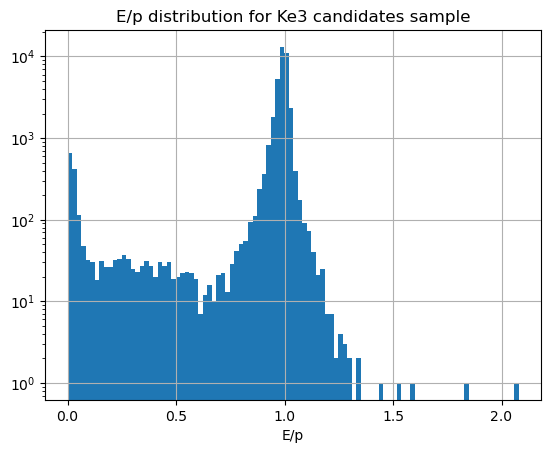

In [5]:
ke3_events["track1_eop"].hist(bins=100)
plt.yscale("log")
plt.xlabel("E/p")
plt.title("E/p distribution for Ke3 candidates sample")

We can see that we do have some polution from another channel. However the electron peak is very clear and enough for our purpose. We want to fit the resolution for the tracks that are in the peak around 1. We can simply reject events with $E/p<0.8$ as those are clearly not electrons having been entirely absorbed inside the LKr

In [6]:
eop_condition = hlf.make_eop_cut(0.8, None, "track1")
ke3_events = hlf.select(ke3_events, [eop_condition])

Let's now extract the expected track energy using the measured momentum, and compute the difference with respect to the measured energy.

In [7]:
e = extract.track(ke3_events, 1)
e_energy = np.sqrt(e["momentum_mag"]**2 + constants.electron_mass**2)
delta_e = e["lkr_energy"] - e_energy

We can now plot and fit this difference. We will try to fit with a Gaussian model, and also with a double Gaussian model

Single Gaussian reduced Chi2: 33.18
Double Gaussian reduced Chi2: 6.49


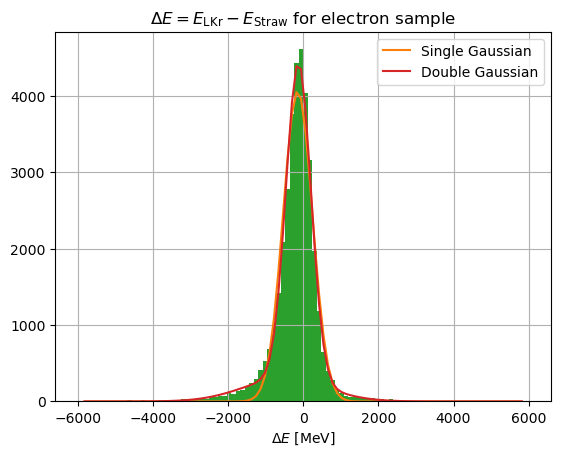

In [8]:
# Prepare a figure
ax = plt.figure().gca()

gauss_fit = stats.perform_fit(delta_e, bins=100, display_range=(-6000, 6000), ax=ax, model_wrapper=stats.gaussian_wrapper, fit_label="Single Gaussian")
gauss2_fit = stats.perform_fit(delta_e, bins=100, display_range=(-6000, 6000), ax=ax, model_wrapper=stats.gaussian2_wrapper, fit_label="Double Gaussian")
plt.xlabel("$\Delta E$ [MeV]")
plt.title(r"$\Delta E = E_\mathrm{LKr} - E_\mathrm{Straw}$ for electron sample")
print(f"Single Gaussian reduced Chi2: {gauss_fit.redchi:.2f}")
print(f"Double Gaussian reduced Chi2: {gauss2_fit.redchi:.2f}")

We can see in this case that the double Gaussian looks much better, both visually and comparing the reduced Chi2. We are therefore going to use the result of the double Gaussian model.

In [9]:
gauss2_fit

We can conclude two things from this fit result:
 - The mean of both Gaussians are slightly but significantly shifted to negative value. This means that the measured energy is always a little less than what we can expect from the momentum measurement (but we cannot tell from this only which one, if any, is more correct).
 - The energy resolution, measured using the $\sigma$ of the dominating Gaussian is around $\sigma_{\Delta E} \sim 327 \pm 6$ MeV.

However we have to keep in mind that this resolution is the convolution of the LKr energy resolution and the Spectrometer momentum resolution.
$$\Delta E = E_\text{LKr} - E_\text{Straw}$$
$$\sigma_{\Delta E} = \sqrt{\sigma_{E_\text{LKr}}^2 + \sigma_{E_\text{Straw}}^2} \sim 327 \pm 6~\text{MeV}$$
We will however assume in the following that the Straw resolution is *small* with respect to the LKr resolution and can therefore be neglected at first order.

We also know that the resolution on the energy is not constant and depends on the energy itself. So we can select ranges of energy, repeat this procedure and extract the sigma for each range.

In [10]:
# Bin the energies between 0 and 80 GeV in bins of 5 GeV
bin_size = 5000
cut = pd.cut(e_energy, np.arange(0,80000, bin_size), labels=False)

# Prepare arrays to store the fit results (bin center, sigma, fit error on sigma)
energy = []
values = []
err = []

# Loop over the bins in increasing order
for binID in cut.value_counts().sort_index().index:
    # Select only the tracks in the current bin
    delta_e_bin = delta_e.loc[cut==binID]

    # Remove bins containing too little stat (request at least 100 tracks in the bin)
    if(len(delta_e_bin)<=100):
        continue

    # Perform the fit, using the double Gaussian model
    fitr = stats.perform_fit(delta_e_bin, bins=100, display_range=(-6000, 6000), model_wrapper=stats.gaussian2_wrapper)

    # Fill the arrays with the results
    energy_val = binID*bin_size + bin_size/2.
    energy.append(energy_val)
    values.append(fitr.params["m0_sigma"].value)
    err.append(fitr.params["m0_sigma"].stderr)

# Transform the result arrays into numpy array for easier processing later
energy = np.array(energy)
values = np.array(values)
err = np.array(err)

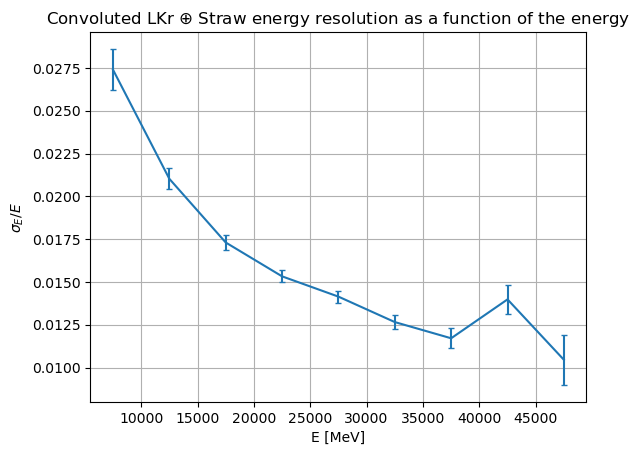

In [11]:
# Plot the relative resolution (sigma/E)
plt.errorbar(energy, values/energy, yerr=err/energy, capsize=2)
plt.title("Convoluted LKr $\oplus$ Straw energy resolution as a function of the energy")
plt.ylabel("$\sigma_E/E$")
plt.xlabel("E [MeV]")
plt.grid("both")

The curve above corresponds to the relative resolution $\frac{\sigma_E}{E}$. This can be parametrized as $\frac{\sigma_E}{E} = a \oplus \frac{b}{\sqrt{E}} \oplus \frac{c}{E} = a \oplus bE^{-1/2} \oplus cE^{-1}$ (with E in GeV to be able to compare with the official model). Let's fit the curve with this model.

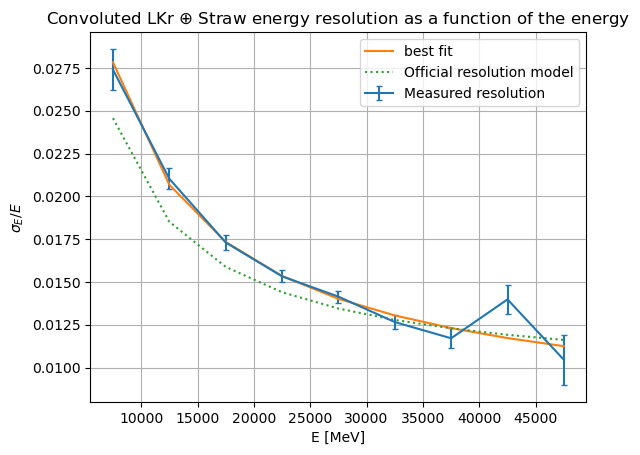

In [12]:
# Define the model 
def lkr_resolution_model(E, a, b, c):
    E = E/1000 # E in GeV for the model
    return np.sqrt(a**2 + (b/np.sqrt(E))**2 + (c/E)**2)

# Create the lmfit model
model = Model(lkr_resolution_model)
# Initial guess for the parameters (not unreasonable)
params = model.make_params(a = 0.01, b=0.01, c=0.01)

# Perform the fit
result = model.fit(values/energy, params, E=energy, weights=1/(err/energy))

# Plot the result
plt.errorbar(energy, values/energy, yerr=err/energy, capsize=2, label="Measured resolution")
plt.plot(energy, result.best_fit, '-', label='best fit')
plt.plot(energy, lkr_resolution_model(energy, 0.009, 0.048, 0.11), ':', label='Official resolution model')
plt.legend()
plt.title("Convoluted LKr $\oplus$ Straw energy resolution as a function of the energy")
plt.ylabel("$\sigma_E/E$")
plt.xlabel("E [MeV]")
plt.grid("both")

# Print the fit result
result

In [13]:
print(f"a = {result.params['a'].value:.1%} +- {result.params['a'].stderr:.1%}")
print(f"b = {result.params['b'].value:.1%} +- {result.params['b'].stderr:.1%}")
print(f"c = {result.params['c'].value:.1%} +- {result.params['c'].stderr:.1%}")

a = 0.6% +- 0.3%
b = 6.2% +- 1.2%
c = 11.2% +- 5.6%


The officially recognized resolution is 
$$\frac{\sigma_E}{E} = 0.9\% \oplus \frac{4.8\%}{\sqrt{E}} \oplus \frac{11\%}{E}$$
while our measurement provides:
$$\frac{\sigma_E}{E} = 0.6\% \oplus \frac{6.1\%}{\sqrt{E}} \oplus \frac{11.7\%}{E}$$

This result is not too bad, parameters 'a' and 'c' are very close to their official value and 'b' is only a couple of percents away (but within uncertainties).

# Spectrometer momentum resolution

## Using data
To measure the momentum resolution of the Spectrometer, we can use closed kinematics events involving tracks only (K3pi). In this way, we can select one of the tracks and reconstruct it from the rest of the event (the beam momentum and the two other tracks) to give us the expected momentum. This can then be compared with the measured momentum of the track. The resolution on this difference is a convolution of three times the Spectrometer momentum resolution (once for each track) and the beam momentum resolution.

In [14]:
# Define our momentum and missing mass squared peaks parameters, as in the PID notebook
m_center = constants.kaon_charged_mass
m_sigma = 1

# --- Define the selection cuts we will need ---
# Event topology
three_tracks_cond = hlf.make_exists_cut(["track1", "track2", "track3"], ["cluster1", "cluster2"])
# Invariant mass
ptot_condition = hlf.make_invariant_mass_cut((m_center-5*m_sigma), (m_center+5*m_sigma), mass_assignments={"track1": constants.pion_charged_mass, "track2": constants.pion_charged_mass, "track3": constants.pion_charged_mass})

In [15]:
k3pi = hlf.select(data, [three_tracks_cond, ptot_condition])

In [16]:
# Extract negative tracks and positive tracks
# Positive will be pos1 and pos2, arbitrarily, doesn't matter

# Extract tracks
t1 = hlf.set_mass(extract.track(k3pi, 1), constants.pion_charged_mass)
t2 = hlf.set_mass(extract.track(k3pi, 2), constants.pion_charged_mass)
t3 = hlf.set_mass(extract.track(k3pi, 3), constants.pion_charged_mass)

# Extract negatives from t1, t2, t3 and store the corresponding 2 positive tracks in their respective arrays.
# Then rotate and do it again (this is only to put that in a loop and avoid 3 repetitions of the code
# Need to do beam at the same time to take care of index misalignment
t_neg_arr = []
t_pos1_arr = []
t_pos2_arr = []
beam_arr = []
beam = extract.get_beam(k3pi)
t = [t1, t2, t3]
for i in range(3):
    neg_tracks = t[0]["charge"]==-1
    t_neg = t[0].loc[neg_tracks]
    t_pos1 = t[1].loc[neg_tracks]
    t_pos2 = t[2].loc[neg_tracks]
    t_neg_arr.append(t_neg)
    t_pos1_arr.append(t_pos1)
    t_pos2_arr.append(t_pos2)
    beam_arr.append(beam.loc[neg_tracks])
    t = [t[1], t[2], t[0]]

# Merge the dataframes in the arrays
t_neg = pd.concat(t_neg_arr)#.reset_index()
t_pos1 = pd.concat(t_pos1_arr)#.reset_index()
t_pos2 = pd.concat(t_pos2_arr)#.reset_index()
beam = pd.concat(beam_arr)

In [17]:
# We will choose t_pos2 as the tested track because we want to test performances on a positive track. Which one doesn't matter
expected = hlf.three_vectors_sum([beam, hlf.three_vector_invert(t_neg), hlf.three_vector_invert(t_pos1)])
# And compute the delta between the expected and measured value
delta_p = expected["momentum_mag"] - t_pos2["momentum_mag"]

Text(0.5, 1.0, '$\\Delta p = p_\\mathrm{K3pi} - p_\\mathrm{Straw}$ for K3pi sample')

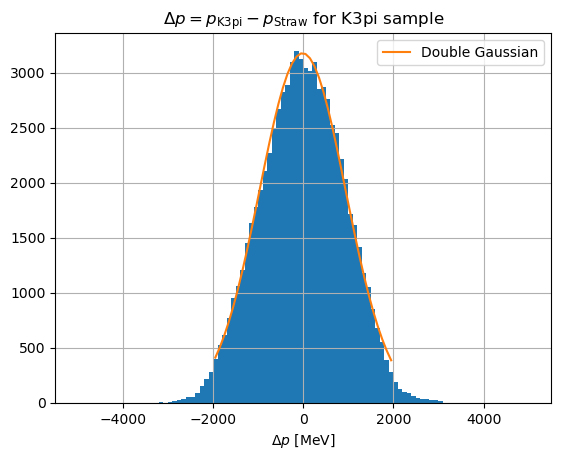

In [18]:
gauss2_fit = stats.perform_fit(delta_p, bins=100, display_range=(-5000, 5000), fit_range=(-2000, 2000), plot=True, model_wrapper=stats.gaussian_wrapper, fit_label="Double Gaussian")
plt.xlabel("$\Delta p$ [MeV]")
plt.title(r"$\Delta p = p_\mathrm{K3pi} - p_\mathrm{Straw}$ for K3pi sample")
#plt.yscale("log")

In [19]:
gauss2_fit

Fit result is ~1000 MeV but this is $\sigma^2 = \sigma^2_{t1} + \sigma^2_{t2} + \sigma^2_{t3} + \sigma^2_\mathrm{Beam} \approx 3\sigma^2_\mathrm{Straw} + \sigma^2_\mathrm{Beam}$
If we want the Straw resolution, we would have to take into account the Beam resolution:
$$\sigma_\mathrm{Straw} = \sqrt{\frac{\sigma^2 - \sigma^2_\mathrm{Beam}}{3}}$$

However the beam resolution is not known and can be quite large as it is only statistically measured over time. Let's make an exercise:  
Starting from the measured resolution from the fit above, let's apply the formula and estimate the 'true' Straw single track resolution as a function of the beam resolution.

Text(0, 0.5, '$\\sigma_\\mathrm{Straw}$ [MeV]')

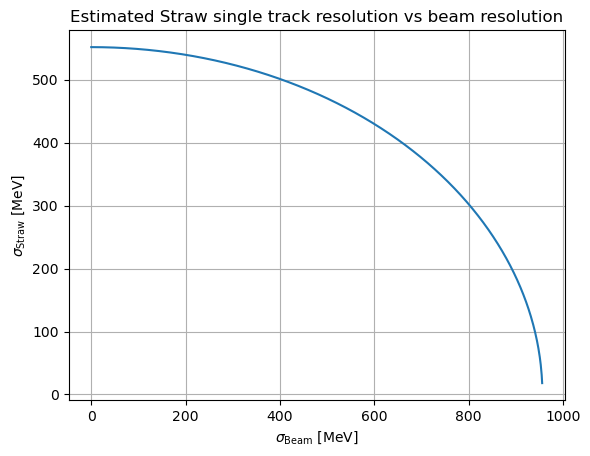

In [20]:
# Get the measured resolution
measured_sigma = gauss2_fit.params["sigma"].value

# Generate beam resolution from 0 to the measured resolution (cannot be higher, else the measured resolution would be higher)
beam_res = np.arange(0,measured_sigma)

# Compute the estimated Straw single track resolution using the formula and plot it
sigma_straw = np.sqrt((gauss2_fit.params["sigma"].value**2 - beam_res**2)/3)
plt.plot(beam_res, sigma_straw)
plt.grid("both")
plt.title("Estimated Straw single track resolution vs beam resolution")
plt.xlabel("$\sigma_\mathrm{Beam}$ [MeV]")
plt.ylabel("$\sigma_\mathrm{Straw}$ [MeV]")

We see that depending on the beam resolution we can actually estimate any Straw momentum resolution between ~550 MeV and 0 MeV.

Similarly to the LKr case, we can again compute the resolution in momentum bins. Doing this, we will record both the "raw" resolution (the sigma of $p_\text{exp}-p_\text{meas}$) but also the Straw "single-track resolution" using one of the most extreme case above where the raw resolution would be almost entirely due to the beam resolution ($\sigma_\text{Beam} = 870$ MeV).

In [21]:
# Bin the momentum between 0 and 80 GeV in bins of 5 GeV
bin_size = 5000
cut = pd.cut(expected["momentum_mag"], np.arange(0,80000, bin_size), labels=False)

# Prepare arrays to store the fit results (bin center, sigma, sigma_single_track, fit error on sigma)
momentum = []
values = []
values_single = []
err = []

# Loop over the bins in increasing order
for binID in cut.value_counts().sort_index().index:
    # Select only the tracks in the current bin
    dp = delta_p.loc[cut==binID]

    # Remove bins containing too little stat (request at least 100 tracks in the bin)
    if(len(dp)<=100):
        continue

    # Perform the fit, using the single Gaussian model
    fitr = stats.perform_fit(dp, bins=100, display_range=(-3000, 3000))

    # Extract the single track sigma and fill the arrays with the results
    p = binID*bin_size + bin_size/2.
    momentum.append(p)
    sigma = fitr.params["sigma"].value
    sigma_beam = 870
    sigma_single = np.sqrt((sigma**2 - sigma_beam**2)/3)
    values.append(sigma)
    values_single.append(sigma_single)
    err.append(fitr.params["sigma"].stderr)

# Transform the result arrays into numpy array for easier processing later
momentum = np.array(momentum)
values = np.array(values)
values_single = np.array(values_single)
err = np.array(err)

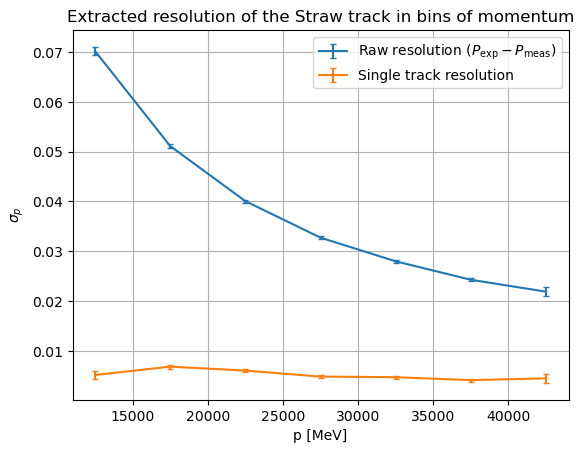

In [22]:
# Plot the relative resolution (sigma/E) for the fitted sigma (raw) and the single track sigma (computed)
plt.errorbar(momentum, values/momentum, yerr=err/momentum, capsize=2, label="Raw resolution ($P_\mathrm{exp} - P_\mathrm{meas}$)")
plt.errorbar(momentum, values_single/momentum, yerr=err/momentum, capsize=2, label="Single track resolution")
plt.legend()
plt.title("Extracted resolution of the Straw track in bins of momentum")
plt.xlabel("p [MeV]")
plt.ylabel("$\sigma_p$")
plt.grid("both")

The curve above corresponds to the relative resolution $\frac{\sigma_p}{p}$. This can be parametrized as $\frac{\sigma_p}{p} = a \oplus bp$ (with $p$ in GeV to be able to compare with the official model). Let's fit the curve with this model.

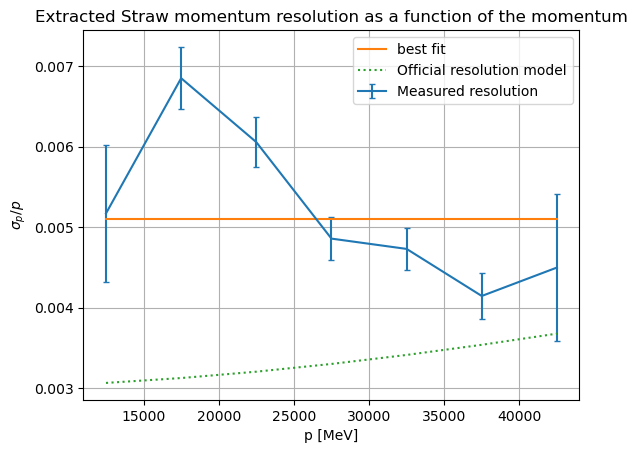

In [23]:
# Define the model 
def straw_resolution_model(P, a, b):
    P = P/1000 # P in GeV for the model
    return np.sqrt(a**2 + (b*P)**2)

# Create the lmfit model
model = Model(straw_resolution_model)
# Initial guess for the parameters (not unreasonable)
params = model.make_params(a = 0.01, b=0.001)

# Perform the fit
result = model.fit(values_single/momentum, params, P=momentum, weights=1/(err/momentum))

# Plot the result
plt.errorbar(momentum, values_single/momentum, yerr=err/momentum, capsize=2, label="Measured resolution")
plt.plot(momentum, result.best_fit, '-', label='best fit')
plt.plot(momentum, straw_resolution_model(momentum, 0.003, 0.00005), ':', label='Official resolution model')
plt.legend()
plt.title("Extracted Straw momentum resolution as a function of the momentum")
plt.ylabel("$\sigma_p/p$")
plt.xlabel("p [MeV]")
plt.grid("both")

# Print the fit result
result

In [24]:
print(f"a = {result.params['a'].value:.1%} +- {result.params['a'].stderr:.1%}")
print(f"b = {result.params['b'].value:.1%} +- {result.params['b'].stderr:.1%}")

a = 0.5% +- 0.1%
b = 0.0% +- 361.7%


The officially recognized resolution is 
$$\frac{\sigma_p}{p} = 0.3\% \oplus 0.005\%p$$
while our measurement provides:
$$\frac{\sigma_p}{p} = 0.5\% \oplus 0.0\%p$$

From the two plots above, it is very clear that the measured "raw" resolution is very far away from the official value. The functional shape of the curve is not even similar. This means that our measurement didn't work at all and is indeed dominated by the resolution on the reference value (i.e. probably the beam component). Taking into account a very high beam resolution, we reach something closer to the official value (parameter 'a' is only a fraction of percent away from the real value, but 'b' cannot be measured). Given the measurement shown on the plot above, it is however very doubtful that we can actually measure anything meaningful in this way.

We can use a different technique to extract the resolution from Monte-Carlo simulations

# From Simulation
Instead we are now going to use simulated data and use as reference the exact real momentum that was input in the simulation

In [25]:
# Import both the k3pi reconstructed sample, and the k3pi mc truth sample
k3pi, _ = prepare.import_root_files(["data/k3pi.root"], total_limit=500000)
k3pi_mc = prepare.import_root_file_mc_truth("data/k3pi.root", limit=500000)

In [26]:
# A bit of manipulation to make association between reco - mc truth easier - Use run,burst,event as index
k3pi_mc = k3pi_mc.set_index(["run", "burst", "event_time"])
k3pi = k3pi.set_index(["run", "burst", "event_time"])
# Then drop any duplicates (sometimes we find two events in the same event)
k3pi = k3pi.loc[~k3pi.index.duplicated()]
k3pi_mc = k3pi_mc.loc[~k3pi_mc.index.duplicated()]

The difficulty here is to uniquely associated each reco track with its corresponding MC truth track. Each sample has three tracks. So we will start with reco track 1 and MC truch track 1 and associated those that belong together. We do not know exactly which one belong together, we can only guess. This guess is based on the track direction (or equivalently slope). Due to kinematics, it is very unlikely for two tracks to go in the same direction. Therefore if a reco track has the same direction (within some uncertainties) than a MC track, they should belong together. Once this is done we will repeat the process for reco track 1 and MC truth track 2, then MC truth track 3, then repeat with reco track 2 and 3. By the end of this procedure we should have a complete sample of statistically well associated reco and MC truth tracks.

In [27]:
# Prepare the lists where we will put the result of each step
track_assoc_list = []
mc_track_assoc_list = []

# Loop over the reco tracks from 1 to 3
for reco_track_id in np.arange(1, 4):
    t1 = extract.track(k3pi, reco_track_id)

    # Compute the reco slopes
    slope_x = t1["direction_x"]/t1["direction_z"]
    slope_y = t1["direction_y"]/t1["direction_z"]
    
    # Loop over the MC tracks from 1 to 3
    for mc_track_id in np.arange(1,4):
        t1_mc = extract.track(k3pi_mc, mc_track_id)
    
        # Compute the MC truth slopes
        slope_x_mc = t1_mc["direction_x"]/t1_mc["direction_z"]
        slope_y_mc = t1_mc["direction_y"]/t1_mc["direction_z"]

        # Request that the reco and MC truth slopes are close to each other both in X and Y
        associated_x = np.abs(slope_x - slope_x_mc)<5e-5
        associated_y = np.abs(slope_y - slope_y_mc)<5e-5

        # Finally select the reco and MC truth tracks that satisfy the conditions
        track_assoc_list.append(t1.loc[associated_x & associated_y])
        mc_track_assoc_list.append(t1_mc.loc[associated_x & associated_y])

# Merge all the small dataframes into one dataframe
mc_tracks = pd.concat(mc_track_assoc_list)
reco_tracks = pd.concat(track_assoc_list)

Now that this is done, let's finally have a look at the distribution:

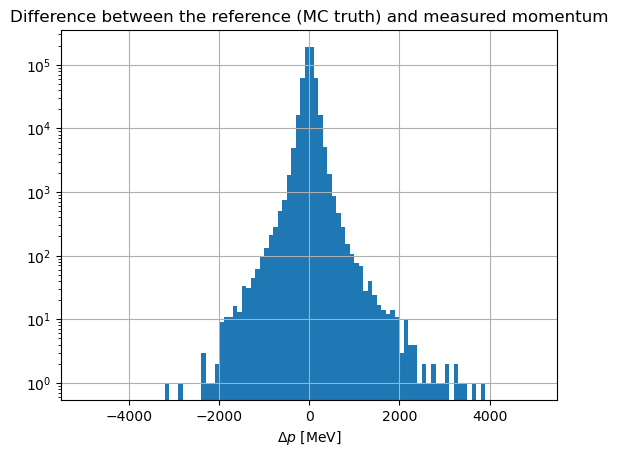

In [28]:
delta_p = (mc_tracks["momentum_mag"] - reco_tracks["momentum_mag"])
delta_p.hist(bins=100, range=(-5000, 5000))
plt.yscale("log")
plt.xlabel("$\Delta p$ [MeV]")
_ = plt.title("Difference between the reference (MC truth) and measured momentum")

This does not look Gaussian anymore. Let's perform our usual double Gaussian fit anyways and assume that the result is still meaningful.

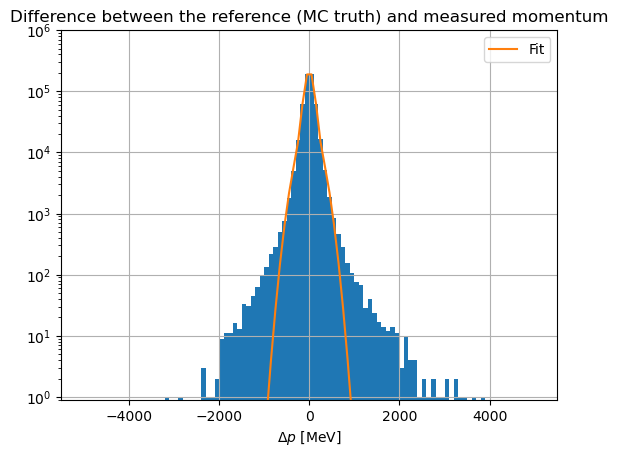

In [29]:
result = stats.perform_fit(delta_p, bins=100, display_range=(-5000, 5000), plot=True, model_wrapper=stats.gaussian2_wrapper)
plt.yscale("log")
plt.ylim(bottom=0.9, top=1e6)
plt.xlabel("$\Delta p$ [MeV]")
_ = plt.title("Difference between the reference (MC truth) and measured momentum")

In [30]:
result

The result gives us a resolution of $\sigma_p = 87$ MeV. We are now close to the level of the official resolution. We can as usual perform the fit in bins of momentum:

In [31]:
# Bin the momentum between 0 and 80 GeV in bins of 5 GeV
bin_size = 5000
cut = pd.cut(mc_tracks["momentum_mag"], np.arange(0,80000, bin_size), labels=False)

# Prepare arrays to store the fit results (bin center, sigma, sigma_single_track, fit error on sigma)
momentum = []
values = []
err = []

# Loop over the bins in increasing order
for binID in cut.value_counts().sort_index().index:
    # Select only the tracks in the current bin
    dp = delta_p.loc[cut==binID]

    # Remove bins containing too little stat (request at least 100 tracks in the bin)
    if(len(dp)<=100):
        continue

    # Perform the fit, using the single Gaussian model
    fitr = stats.perform_fit(dp, bins=100, display_range=(-3000, 3000))

    # Extract the single track sigma and fill the arrays with the results
    p = binID*bin_size + bin_size/2.
    momentum.append(p)
    sigma = fitr.params["sigma"].value
    values.append(sigma)
    err.append(fitr.params["sigma"].stderr)

# Transform the result arrays into numpy array for easier processing later
momentum = np.array(momentum)
values = np.array(values)
err = np.array(err)

Then we will display it and fit the curve with the Straw model.

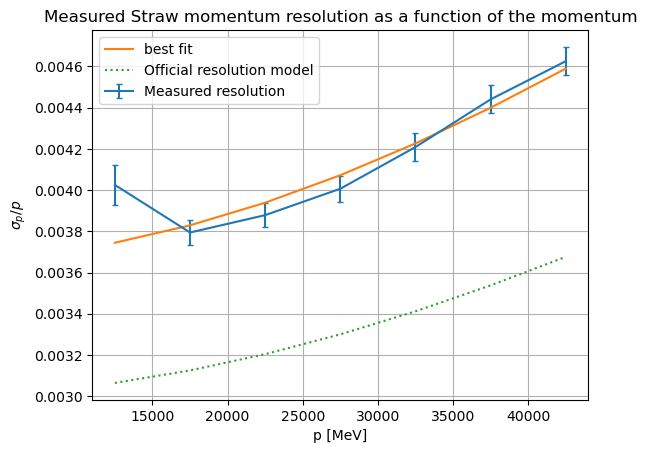

In [32]:
# Create the lmfit model
model = Model(straw_resolution_model)
# Initial guess for the parameters (not unreasonable)
params = model.make_params(a = 0.01, b=0.001)

# Perform the fit
result = model.fit(values/momentum, params, P=momentum, weights=1/(err/momentum))

# Plot the result
plt.errorbar(momentum, values/momentum, yerr=err/momentum, capsize=2, label="Measured resolution")
plt.plot(momentum, result.best_fit, '-', label='best fit')
plt.plot(momentum, straw_resolution_model(momentum, 0.003, 0.00005), ':', label='Official resolution model')
plt.legend()
plt.title("Measured Straw momentum resolution as a function of the momentum")
plt.ylabel("$\sigma_p/p$")
plt.xlabel("p [MeV]")
plt.grid("both")

# Print the fit result
result

In [33]:
print(f"a = {result.params['a'].value:.2%} +- {result.params['a'].stderr:.2%}")
print(f"b = {result.params['b'].value:.3%} +- {result.params['b'].stderr:.3%}")

a = 0.37% +- 0.01%
b = 0.007% +- 0.000%


As a reminder from earlier, the officially recognized resolution is 
$$\frac{\sigma_p}{p} = 0.3\% \oplus 0.005\%p$$

Our measurement on MC simulations now provides:
$$\frac{\sigma_p}{p} = 0.36\% \oplus 0.007\%p$$

We are very close, only one of the parameter is now slightly off! Of course this resolution is measured on MC simulation, so it should be what we set in the simulation software. However some kinematic values are very sensitive to the resolution of the Straw momentum. One such example is the reconstructed invariant mass. In the exercise below, we can compute the reconstructed $3\pi$ invariant mass on the MC truth sample and see which resolution we achieve on that mass. We can repeat this process multiple times, smearing the momentum of the tracks according to a resolution of our choice. In this way we will obtain the curve giving us the mass resolution as a function of the track resolution.

In [34]:
# Prepare arrays for the results
smearing_list = []
resolution_list = []
mass_assignment = {"track1": constants.pion_charged_mass, "track2": constants.pion_charged_mass, "track3": constants.pion_charged_mass}

# So you see something happening while waiting for the result (can take a little while, we will perform 50 fits)
from tqdm.notebook import tqdm

# We will choose 20 smearing (resolution) values uniformly spaced in log scale, from 1 to 1e3
for smearing in tqdm(np.logspace(1, 3, 20)):
    # We don't want to modify the original data, so we do a copy
    k3pi_mc_smeared = k3pi_mc.copy()

    # We smear all three momentum with the same resolution
    k3pi_mc_smeared["track1_momentum_ma"] = np.random.normal(k3pi_mc_smeared["track1_momentum_mag"], smearing)
    k3pi_mc_smeared["track2_momentum_mag"] = np.random.normal(k3pi_mc_smeared["track2_momentum_mag"], smearing)
    k3pi_mc_smeared["track3_momentum_mag"] = np.random.normal(k3pi_mc_smeared["track3_momentum_mag"], smearing)

    # Compute our target value
    inv_mass = hlf.invariant_mass(k3pi_mc_smeared, mass_assignments=mass_assignment)
    kaon_mass_diff = inv_mass - constants.kaon_charged_mass

    # We want to use a fitting range that is reasonable for each trial, so we will fit up to 10% after the last value on the plot
    range_max = np.max(np.abs(kaon_mass_diff))*1.1

    # Perform the fit and get the result
    result = stats.perform_fit(kaon_mass_diff, bins=100, display_range=(-range_max, range_max), plot=False, model_wrapper=stats.gaussian2_wrapper)
    resolution_list.append(result.params["m0_sigma"].value)
    smearing_list.append(smearing)

  0%|          | 0/20 [00:00<?, ?it/s]

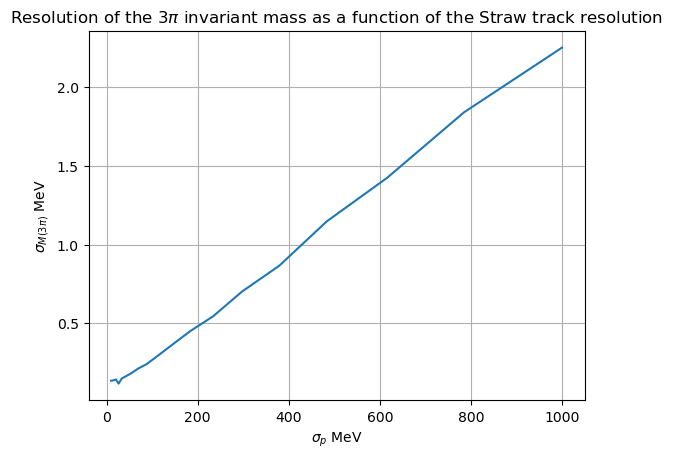

In [35]:
# And now we plot the result
plt.plot(smearing_list, resolution_list)
plt.grid("both")
plt.ylabel("$\sigma_{M(3\pi)}$ MeV")
plt.xlabel("$\sigma_p$ MeV")
_ = plt.title("Resolution of the $3\pi$ invariant mass as a function of the Straw track resolution")

We have a linear relation, so we can easily infer the track resolution based on the $3\pi$ mass resolution (assuming this is the only factor contributing). Let's measure the resolution we have both in data and in MC.

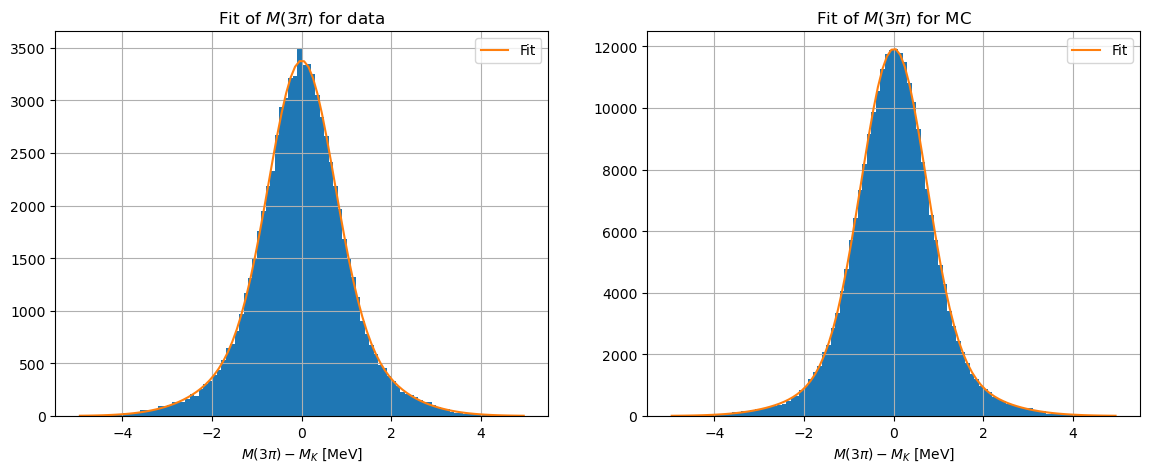

In [36]:
# Compute the invariant mass with respect to the Kaon mass for both data and MC
inv_mass_diff_data = hlf.invariant_mass(data.loc[data["event_type"]==constants.event_type_map["k3pi"]], mass_assignments=mass_assignment) - constants.kaon_charged_mass
inv_mass_diff_mc = hlf.invariant_mass(k3pi, mass_assignments=mass_assignment) - constants.kaon_charged_mass

# Prepare the plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Perform the fits
result_data = stats.perform_fit(inv_mass_diff_data, bins=100, display_range=(-5, 5), ax=ax[0], model_wrapper=stats.gaussian2_wrapper)
result_mc = stats.perform_fit(inv_mass_diff_mc, bins=100, display_range=(-5, 5), ax=ax[1], model_wrapper=stats.gaussian2_wrapper)
ax[0].set_title("Fit of $M(3\pi)$ for data")
ax[0].set_xlabel("$M(3\pi)-M_K$ [MeV]")
ax[1].set_title("Fit of $M(3\pi)$ for MC")
_ = ax[1].set_xlabel("$M(3\pi)-M_K$ [MeV]")

In [37]:
print(f"K3pi invariant mass resolution for data: {result_data.params['m0_sigma'].value:.3f} +- {result_data.params['m0_sigma'].stderr:.3f} MeV")
print(f"K3pi invariant mass resolution for MC:   {result_mc.params['m0_sigma'].value:.3f} +- {result_mc.params['m0_sigma'].stderr:.3f} MeV")

K3pi invariant mass resolution for data: 0.710 +- 0.009 MeV
K3pi invariant mass resolution for MC:   0.714 +- 0.004 MeV


As you can see the resolution are compatible between MC and data. This means that the simulated resolution is reproducing correctly the real resolution, and therefore our estimated MC resolution is actually a good approximation of the resolution we have in data, but were unable to measure directly in data.

The second observation is that the resolution is 0.71 MeV. If we look at the curve of the invariant mass resolution as a function of the momentum resolution, we can see that an invariant mass resolution of 0.71 MeV corresponds to a momentum resolution of ~280 MeV. This is however too high with respect to what we measured in MC (86 MeV). But it was mentioned that the curve above was valid in the assumption that the momentum resolution was the only contribution. There is another important contribution that we did not take into account: the momentum direction. We have assumed while building that curve that the momentum direction is perfectly known. That is in fact incorrect as there is also some resolution to these values (two slopes essentially). We leave this as exercise (you can repeat the process of MC-Reco comparison we did for "momentum_mag" on the slope_x and slope_y values to find out the resolution. Then smear those at the same time as the "momentum_mag" with their own resolution, update the "direction_{x,y,z}" variables accordingly and look at the invariant mass resolution after that.